<a href="https://colab.research.google.com/github/Roshegaa/My-Projects/blob/main/Mobilenet_se_cat_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/rizwan123456789/potato-disease-leaf-datasetpld")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: harikrishnan7777777
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rizwan123456789/potato-disease-leaf-datasetpld


100%|██████████| 37.4M/37.4M [00:03<00:00, 10.3MB/s]


In [ ]:
train_path = './potato-disease-leaf-datasetpld/PLD_3_Classes_256/Training/'
test_path = './potato-disease-leaf-datasetpld/PLD_3_Classes_256/Testing/'
val_path = './potato-disease-leaf-datasetpld/PLD_3_Classes_256/Validation/'

In [ ]:
import os
os.listdir(train_path)
os.listdir(test_path)
os.listdir(val_path)

['Late_Blight', 'Early_Blight', 'Healthy']

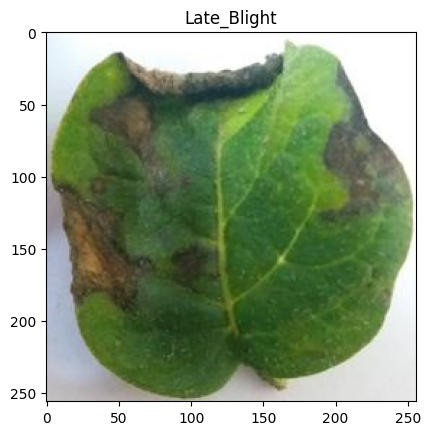

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(train_path+'Late_Blight/Late_Blight_1.jpg')
imgplot = plt.imshow(img)
plt.title("Late_Blight")
plt.show()

In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Multiply, Reshape, Activation


In [ ]:
img_size = (224, 224)


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2602 images belonging to 3 classes.
Found 82 images belonging to 3 classes.


In [ ]:
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


17225924/17225924 [==============================] - 2s 0us/step


In [ ]:
def se_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)

    x = Multiply()([input_tensor, se])
    return x


In [ ]:
def ca_block(input_tensor):
    filters = input_tensor.shape[-1]
    avg_pool = GlobalAveragePooling2D()(input_tensor)
    avg_pool = Dense(filters, activation='relu')(avg_pool)
    avg_pool = Dense(filters, activation='sigmoid')(avg_pool)
    avg_pool = Reshape((1, 1, filters))(avg_pool)

    x = Multiply()([input_tensor, avg_pool])
    return x


In [ ]:
x = base_model.output
x = se_block(x)
x = ca_block(x)
x = GlobalAveragePooling2D()(x)
x = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(
   train_generator,
   epochs=20,
   validation_data=validation_generator
)


Epoch 1/20
82/82 [==============================] - 58s 472ms/step - loss: 0.1826 - accuracy: 0.9343 - val_loss: 0.1820 - val_accuracy: 0.9268
Epoch 2/20
82/82 [==============================] - 38s 464ms/step - loss: 0.1099 - accuracy: 0.9650 - val_loss: 0.8994 - val_accuracy: 0.8171
Epoch 3/20
82/82 [==============================] - 37s 451ms/step - loss: 0.0892 - accuracy: 0.9739 - val_loss: 0.1477 - val_accuracy: 0.9512
Epoch 4/20
82/82 [==============================] - 36s 443ms/step - loss: 0.0687 - accuracy: 0.9792 - val_loss: 0.1322 - val_accuracy: 0.9512
Epoch 5/20
82/82 [==============================] - 37s 449ms/step - loss: 0.0644 - accuracy: 0.9816 - val_loss: 0.0809 - val_accuracy: 0.9634
Epoch 6/20
82/82 [==============================] - 37s 456ms/step - loss: 0.0632 - accuracy: 0.9808 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 7/20
82/82 [==============================] - 37s 456ms/step - loss: 0.0616 - accuracy: 0.9812 - val_loss: 0.1316 - val_accuracy: 0.9512

In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


3/3 [==============================] - 1s 291ms/step - loss: 0.1465 - accuracy: 0.9878
Validation Loss: 0.14648012816905975
Validation Accuracy: 0.9878048896789551


In [ ]:
model.save('mobilenet_se_ca_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = test_path+'Late_Blight/Late_Blight_1.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)


img_array /= 255.0


In [ ]:
class_labels = ['Early_Blight', 'Healthy', 'Late_Blight']
predicted_label = class_labels[predicted_class[0]]

print(f'The model predicts: {predicted_label}')


The model predicts: Late_Blight


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
save_path = '/content/drive/MyDrive/mobilenet_se_ca_model.h5'


In [ ]:
model.save(save_path)


In [ ]:
!ls /content/drive/MyDrive/


'Colab Notebooks'   mobilenet_se_ca_model.h5


In [ ]:
test_generator = train_datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 82 images belonging to 3 classes.


In [ ]:
predicted_masks = model.predict(test_generator)


3/3 [==============================] - 2s 308ms/step


In [ ]:
predicted_masks = np.argmax(predicted_masks, axis=-1)


In [ ]:
true_masks = test_generator.classes



In [ ]:
predicted_flat = predicted_masks.flatten()
true_flat = true_masks.flatten()


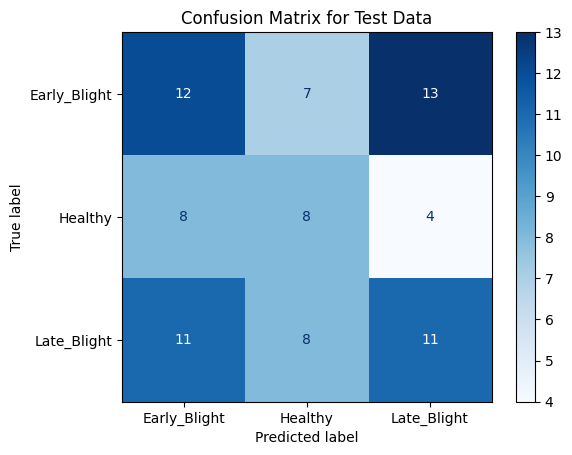

In [ ]:

labels = [0, 1, 2]


cm = confusion_matrix(true_flat, predicted_flat, labels=labels)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Early_Blight', 'Healthy', 'Late_Blight'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Test Data')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

true_labels = true_flat
predicted_labels = predicted_flat

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average=None, labels=[0, 1, 2])
recall = recall_score(true_labels, predicted_labels, average=None, labels=[0, 1, 2])
f1 = f1_score(true_labels, predicted_labels, average=None, labels=[0, 1, 2])

print("\nMetrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Late Blight, Healthy, Early Blight): {precision}")
print(f"Recall (Late Blight, Healthy, Early Blight): {recall}")
print(f"F1 Score (Late Blight, Healthy, Early Blight): {f1}")



Metrics:
Accuracy: 0.38
Precision (Late Blight, Healthy, Early Blight): [0.38709677 0.34782609 0.39285714]
Recall (Late Blight, Healthy, Early Blight): [0.375      0.4        0.36666667]
F1 Score (Late Blight, Healthy, Early Blight): [0.38095238 0.37209302 0.37931034]
